# Big Data para Dados Públicos

##### Maciel C. Vidal

Na aula de hoje iremos continuar a trabalhar com o Dask, na mesma proposta da aula passada:
- Nosso computador pessoal
- Ferramentas que permitem processamento paralelo
- Que não carregam todo o arquivo em memória

## Dask

O Dask (https://dask.org) é uma ferramenta open-source escrita em Python (https://github.com/dask/dask), que permite análise de dados utilizando processamento paralelo.

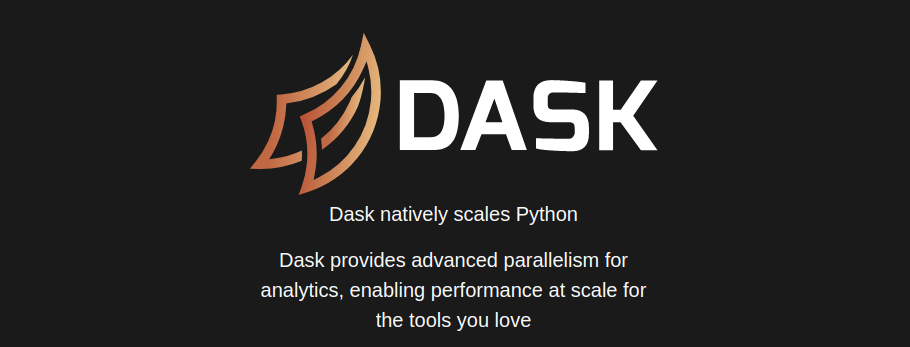

## Importando as bibliotecas necessárias

Agora, vamos importar as bibliotecas necessárias:

In [1]:
# Para utilizar recursos do sistema
import os
import sys

# Bibliotecas DASK
import dask
from dask.distributed import Client
import dask.dataframe as dd # similar ao pandas
import dask.multiprocessing

# Para plot
%matplotlib inline
import matplotlib.pyplot as plt

Caso obtenha algum erro, utilize o **!pip install** para instalar a biblioteca ausente!

Vamos conferir com qual versão da biblioteca **Dask** estamos trabalhando?

In [2]:
dask.__version__

'2024.8.0'

In [3]:
!python -m pip show dask

Name: dask
Version: 2024.8.0
Summary: Parallel PyData with Task Scheduling
Home-page: https://github.com/dask/dask/
Author: 
Author-email: 
License: BSD-3-Clause
Location: c:\Users\guoli\Documents\Insper\BigData\venv\Lib\site-packages
Requires: click, cloudpickle, fsspec, packaging, partd, pyyaml, toolz
Required-by: dask-expr, distributed


Você também pode conferir de onde está executando o Python e qual a versão

In [4]:
print('Executável:')
print(sys.executable)

print('\nVersão do Python:')
print(sys.version)

Executável:
c:\Users\guoli\Documents\Insper\BigData\venv\Scripts\python.exe

Versão do Python:
3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)]


Vamos conferir em qual diretório iremos trabalhar (é o diretório do notebook)

In [5]:
print('O seu notebook está na pasta:')
print(os.getcwd())

O seu notebook está na pasta:
c:\Users\guoli\Documents\Insper\BigData\Aula_03


## Configurando um ambiente Dask

Agora iremos configurar um ambiente Dask para execução das nossas análises. Para isso, iremos criar um **client**

In [6]:
# client.close()
client = Client(n_workers=2, threads_per_worker=2, memory_limit='0.75GB')

perceba que, ao exibir o client, temos acesso a uma URL que nos permitirá acompanhar informações sobre o consumo de recursos durante a execução de tarefas

In [7]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 1.40 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52852,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 1.40 GiB
Comm: tcp://127.0.0.1:52863,Total threads: 2
Dashboard: http://127.0.0.1:52864/status,Memory: 715.26 MiB
Nanny: tcp://127.0.0.1:52855,


Para entender o funcionamento de um Dask Client:

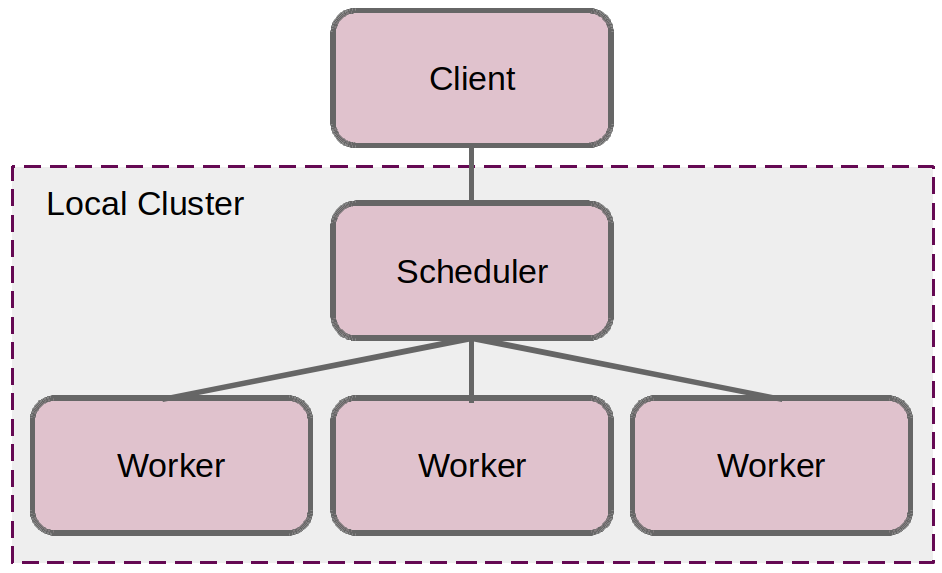

Vamos definir:

- **Client**: ponto de entrada para os usuários que querem consumir recursos computacionais.

- **Scheduler**: gerencia um cluster (grupo) de workers. Distribui tarefas entre eles.

- **Worker**: fazem de fato a análise dos dados. Computam as tarefas atribuídas a eles pelo Scheduler e trocam informações entre sí quando necessário.

## Dask client

Nas aulas anteriores, vimos a interface de Dask DataFrames, onde ao chamar `replace`, `value_counts`, as funções eram calculadas pelo **cluster** no momento que os dados eram requisitados.

### Execução no cluster

Nesta aula veremos formas diferentes de trabalhar com o Dask e utilizá-lo para processamento.

Podemos chamar a função `compute` por exemplo:

In [8]:
# Complete AQUI!
client.compute(5*5)

25

**Pergunta**: O processamento foi calculado localmente ou no cluster?

<div class="alert alert-success">

O processamento foi local, pois já que o ".compute" esta chaamando uma expressão, ele roda localmente.

</div>

Para simular a submissão de processamentos para o cliente Dask, vamos criar uma função em python que recebe um `valor` e uma `porcentagem` de desconto. A função deve devolver o **valor com desconto**.

In [9]:
import time

# Altere a função para fazer o requisitado!
def calcula_valor_com_desconto(valor, porc_desconto):
    return valor * (1 - porc_desconto)

Vamos utilizar a função localmente, como já fazemos em python:

In [10]:
valor = 250.0
desconto = 0.2
valor_final = calcula_valor_com_desconto(valor, desconto)
print(f"O novo valor será {valor_final:.2f}")

O novo valor será 200.00


Funcionou! Mas todo o processamento foi feito localmente, sem uso do cluster.

Para fazer uso do cluster, iremos fazer o `submit` de um processamento:

<div class="alert alert-info">

**Dica**: divida sua tela com o dashboard do dask client e confira se muda algo!

</div>

In [11]:
novo_valor = client.submit(calcula_valor_com_desconto, valor, desconto)

Vamos ver o que foi retornado:

In [12]:
novo_valor

<Future: finished, type: float, key: calcula_valor_com_desconto-616ed03c085db642cba1dddcab7e021c>

Conferindo o tipo da variável:

In [13]:
type(novo_valor)

distributed.client.Future

Bem, o que obtemos não foi o resultado do cálculo, mas sim um **Future**.

Ao fazer o envio para execução remota com Dask, ele retorna imediatamente um **Future** que aponta para a computação em andamento e, eventualmente, para o resultado armazenado. Assim, o status do **Future** pode estar `pending` e passar para `finished` a qualquer momento.

Para obter o resultado, vamos utilizar:

In [14]:
novo_valor.result()

200.0

### Dask Delayed

Nas aulas anteriores, vimos as funções trabalhando de forma `lazy computing`. Assim, ao invés de calcular os resultados imediatamente, o Dask constroi uma representação dos cálculos necessários em um grafo, que é armazenado para processamento posterior, apenas quando os dados são de fato necessários.

Vamos criar uma versão `lazy` da nossa função. A nova função será chamada `delay_calc_desconto`:

In [15]:
delay_calc_desconto = dask.delayed(calcula_valor_com_desconto)
delay_calc_desconto

Delayed('calcula_valor_com_desconto-79b50af4-40b9-46a3-a426-cb189bee0f44')

Para utilizá-la, podemos chamar a função `delay_calc_desconto` passando os argumentos necessários.

In [16]:
total_fatura = delay_calc_desconto(300, 0.1)
total_fatura

Delayed('calcula_valor_com_desconto-6a9e1daa-2510-4d69-aafc-f81520e1d4c9')

<div class="alert alert-info">

Perceba o que é retornado em cada passo

</div>

Podemos visualizar graficamente o grafo de computação da tarefa.

<div class="alert alert-danger">

Será necessário a instalação de bibliotecas e programas para isso para que funcione em sua máquina.

https://graphviz.org/download/

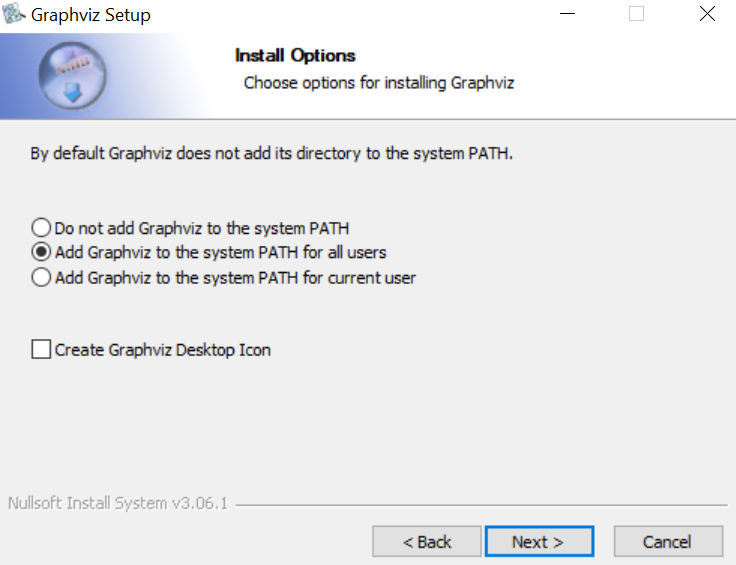

</div>

In [17]:
# !python -m pip install graphviz
# !python -m pip install ipycytoscape

In [18]:
total_fatura.visualize(rankdir='LR')

RuntimeError: No visualization engine detected, please install graphviz or ipycytoscape

Como é uma tarefa com apenas um passo, o grafo é pequeno! Na sequência faremos uma versão mais ampla!

Para obter o resultado, podemos chamar `.compute()` e a função **lazy** será enfim computada pelo cluster!

<div class="alert alert-info">

**Dica**: divida sua tela com o dashboard do dask client e confira se muda algo ao executar a próxima célula!

</div>

In [19]:
total_fatura.compute()

270.0

**Exercício 1**: Crie duas funções:

- Função `calcula_imposto`: recebe um argumentos (`valor_com_desconto`). Se o argumento for acima de `1000.0`, calcule um imposto de `17%`, caso contrário não há imposto.
- Função `soma`: recebe dois argumentos (`valor_com_desconto`, `valor_imposto`) e retorna a soma deles.

Então, crie versões `lazy` destas duas funções e, utilizando estas funções (além da função que calcula o desconto):

- Simule um valor qualquer de compra
- Calcule o valor com desconto considerando porcentagem de 10%
- Calcule o imposto sobre o valor com desconto
- Calcule o valor total utilizando a função lazy de soma
- Visualize o grafo de cálculo
- Compute o resultado

In [20]:
## Seu código AQUI!

In [21]:
# PROF
def calcula_imposto(valor_com_desconto):
    if valor_com_desconto> 1000:
        return valor_com_desconto * 0.17
    return 0.0

def soma(valor_com_desconto, valor_imposto):
    return valor_com_desconto + valor_imposto

delay_calc_imposto = dask.delayed(calcula_imposto)
delay_calc_soma = dask.delayed(soma)

valor = 2500.0
valor_com_desc = delay_calc_desconto(valor, 0.1)
valor_imposto = delay_calc_imposto(valor_com_desc)
valor_total = delay_calc_soma(valor_com_desc, valor_imposto)
valor_total.compute()

2632.5

In [22]:
valor_total.visualize(rankdir='LR')

RuntimeError: No visualization engine detected, please install graphviz or ipycytoscape

### Após terminar o exercício anterior

Agora vamos aplicar a ideia do exercício anterior em múltiplas vendas. Considere uma lista `vendas` que possui o valor de várias vendas realizadas.

Para cada venda, precisamos calcular o valor com desconto, o valor do imposto e o valor total.

A próxima célula faz isso. Vamos criar uma lista `todas_vendas`. Cada elemento desta lista será uma tarefa `lazy`:

In [23]:
%%time
vendas = [50.0, 200.0, 1500.5, 250.0, 700.0, 2000.0]

todas_vendas = []
for valor in vendas:
    valor_com_desc = delay_calc_desconto(valor, 0.1)
    valor_imposto = delay_calc_imposto(valor_com_desc)
    valor_total = delay_calc_soma(valor_com_desc, valor_imposto)
    todas_vendas.append(valor_total)

todas_vendas

CPU times: total: 0 ns
Wall time: 1 ms


[Delayed('soma-17bd54b8-5a06-44eb-a4ab-3aa5bd44efbd'),
 Delayed('soma-729890f1-4cdc-40c9-8ac5-dd3d5578da93'),
 Delayed('soma-c0f2f8c7-17a5-459c-878b-83e535f5876f'),
 Delayed('soma-2a4fb2b0-08d8-4162-a3f8-20e401cca078'),
 Delayed('soma-538e590a-6c6a-46ec-82b4-ea7456ce0df2'),
 Delayed('soma-cd31c7ee-438f-47c8-a5c7-d65064c80932')]

Vamos solicitar que o valor total das venda seja computado:

<div class="alert alert-info">

**Dica**: divida sua tela com o dashboard do dask client e confira se muda algo ao executar a próxima célula!

Perceba que as tarefas serão divididas entre os vários workers do cluster.

</div>

In [24]:
vendas_final = dask.compute(todas_vendas)
vendas_final

([45.0, 180.0, 1580.0265000000002, 225.0, 630.0, 2106.0],)

Perceba que criamos uma cadeia de várias tarefas `lazy`. O cliente Dask gerencia a dependência entre elas (por exemplo, precisamos do valor com desconto para calcular o valor do imposto, veja na aba Graph do dashboard). Assim, cada tarefa é calculada apenas quando suas dependências já estão disponíveis.

## Dask Bags

Já trabalhamos com Dask DataFrames. Agora vamos ver algumas aplicações de Dask Bags.

O Dask Bag implementa operações como `map`, `filter` em coleções de objetos Python genéricos. Ele faz isso em paralelo com um pequeno consumo de memória usando iteradores Python.

Dask bags são frequentemente usadas para paralelizar cálculos simples em dados não estruturados ou semiestruturados, como dados de texto e registros JSON.

Veja mais em https://docs.dask.org/en/stable/bag.html

### Download dos dados

Iremos continuar a uma base de sentimento de review de produtos da Amazon. Os dados foram baixados do Kaggle.

Para facilitar o processamento, criei três versoes dos dados. A ideia é focar na técnica, sem se preocupar tanto por enquanto com o tamanho da informação, assim ganhamos velocidade no processamento e obtenção dos resultados:

- **Base Small**: https://bigdata-22-2.s3.us-east-2.amazonaws.com/amazon_sentiment/amazon_sentiment_json_small.zip
- **Base Medium**: https://bigdata-22-2.s3.us-east-2.amazonaws.com/amazon_sentiment/amazon_sentiment_json_medium.zip
- **Base Large**: https://bigdata-22-2.s3.us-east-2.amazonaws.com/amazon_sentiment/amazon_sentiment_json_large.zip

<div class="alert alert-info">

**Dica**: divida sua tela com o dashboard do dask client e confira se muda algo ao executar a próxima célula!

Perceba que as tarefas serão divididas entre os vários workers do cluster.

</div>

### Formatos de arquivos

Quando vamos trabalhar com uma base de dados nova, uma das principais dificuldades envolve entender o formato de armazenamento dos dados e como trabalhar com eles. É preciso entender que os dados podem estar armazenados nos mais diversos formatos, com diversas codificações, necessitando de tratativas no momento de leitura.

#### Formato CSV

**1) O que é um CSV?**

O formato CSV (*Comma-separated values*) é um formato de arquivo no qual os dados são armazenados em formato de texto. Cada linha identifica um registro e as colunas (variáveis) são identificadas ou truncadas na vírgula.

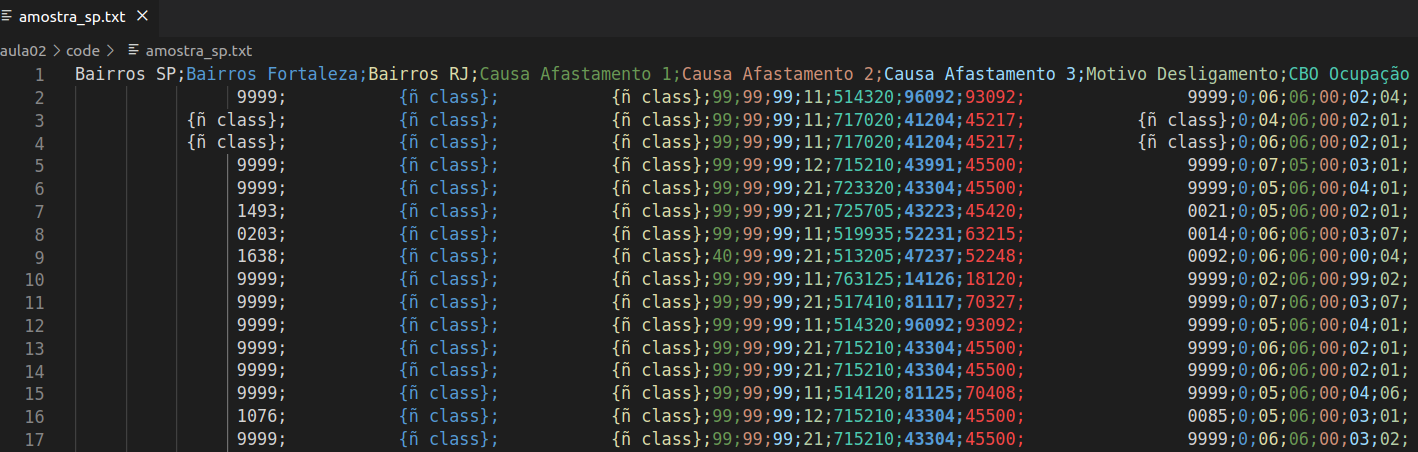

**2) Quais as vantagens do CSV?**

- Formato bastante conhecido, facilitando a disponibilização de dados entre instituições ou pessoas.
- Muitas bibliotecas já trabalham com CSV.

**3) Quais as desvantagens do CSV?**

- É formato de texto, então podemos ter problemas com codificação.
- Não provê *schema* (tipos de dados nas colunas).

#### Formato XLSX

Arquivo de planilhas criadas principalmente com Microsoft Excel seguindo o padrão Open XML (https://en.wikipedia.org/wiki/Office_Open_XML). Armazena dados em formato tabular, com células organizadas em uma grade de linhas e colunas (planilhas). É um formato muito utilizado em ambiente empresarial

#### Formato Apache Parquet

Um formato de código aberto muito utilizado em ambientes Big Data, devido a seu desenho buscando eficiência em ambientes distribuídos (https://databricks.com/glossary/what-is-parquet).

<img src="https://parquet.apache.org/images/FileLayout.gif">

#### Formato JSON

O **JSON** (*JavaScript Object Notation*) é um formato de troca de dados leve e de fácil leitura por humanos. Os dados em JSON são compostos por pares de nome/valor. Um valor pode ser um número, string, arrays, objeto ou nulo.

```json
{
    "sentiment": 2,
    "title": "Great book",
    "text": "This was a great book,I just could not put it down,and could not read it fast enough. Boy what a book the twist and turns in this just keeps you guessing and wanting to know what is going to happen next."
}
```

Por serem representados por strings, é fácil transmiti-los entre um servidor e cliente, como por exemplo quando um aplicativo faz uma requisição HTTP para um servidor web, que responde de volta com JSON. Assim, tornou-se um formato popular de troca de dados entre sistemas e aplicativos modernos.

### Lendo dados

Após fazer o download dos dados e descompactar, vamos lê-los como Dask Bags.

<div class="alert alert-info">

Garanta que, ao descompactar, foi criada a pasta **amazon_sentiment_json_small** com diversos arquivos **JSON** na sua pasta atual de trabalho.

</div>

In [25]:
import dask.bag as db
import json

jd = db.read_text('amazon_sentiment_json_small/amazon_sentiment_json_small/*.json').map(json.loads)
jd

dask.bag<loads, npartitions=2>

A base de dados está dividida em vários arquivos JSON, onde cada linha de cada arquivo representa um registro JSON.

Assim, para que um registro seja lido de forma correta, vamos mapear a função `json.loads` sempre que um elemento for requisitado.

Para obter um ou mais elementos, utilizamos:

In [26]:
jd.take(1)

({'sentiment': 2,
  'title': 'Stuning even for the non-gamer',
  'text': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'},)

In [27]:
jd.take(2)

({'sentiment': 2,
  'title': 'Stuning even for the non-gamer',
  'text': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'},
 {'sentiment': 2,
  'title': 'The best soundtrack ever to anything.',
  'text': "I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel woul

In [28]:
jd.take(2)[0]["title"]

'Stuning even for the non-gamer'

In [29]:
%%time
jd.count().compute()

CPU times: total: 0 ns
Wall time: 39.5 ms


40

### Filtrando dados

#### Filtrar nas colunas

Para filtrar os dados nas colunas ou campos, podemos fazer o `map` de uma função que recebe um registro e retorna apenas a coluna requisitada:

In [30]:
titulos = jd.map(lambda registro: registro["title"])
titulos

dask.bag<lambda, npartitions=2>

In [31]:
titulos.take(3)

('Stuning even for the non-gamer',
 'The best soundtrack ever to anything.',
 'Amazing!')

Vamos tentar entender o que são estes **lambdas**.

Oberse uma maneira diferente de fazer sem usar `lambda`:

In [32]:
def pega_titulo(registro):
    return registro['title']

titulos = jd.map(pega_titulo)

titulos.take(3)

('Stuning even for the non-gamer',
 'The best soundtrack ever to anything.',
 'Amazing!')

Perceba que com o `lambda` podemos fazer uma função sem de fato nomeá-la. Elas são chamadas exatamente disso: funções sem nome, considerado por muitos um péssimo nome rsrs!

O que estamos vendo nesta aula é derivado da programação funcional, uma área muito importante para Big Data! São pequenos detalhes com grandes consequências!

Veja mais um exemplo direto, agora sem usar Dask:

In [33]:
def soma(x, y):
    return x + y

print(soma(10, 12))

22


In [34]:
f = lambda x,y: x + y
print(f(10, 12))

22


#### Filtrar nas linhas

Para filtrar nas linhas, vamos utilizar a função `filter`, aplicando uma função **lambda** que retorna `True` para as linhas que devem ser mantidas, e `False` para as linhas que devem ser removidas:

In [35]:
negativos = jd.filter(lambda linha: linha['sentiment'] == 1)
negativos

dask.bag<filter-lambda, npartitions=2>

In [36]:
negativos.take(3)

({'sentiment': 1,
  'title': 'Buyer beware',
  'text': 'This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon\'s family and friends--or perhaps, by herself! I can\'t imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad enough to be entered into some kind of a "worst book" contest. I can\'t believe Amazon even sells this kind of thing. Maybe I can offer them my 8th grade term paper on "To Kill a Mockingbird"--a book I am quite sure Ms. Haddon never heard of. Anyway, unless you are in a mood to send a book to someone as a joke---stay far, far away from this one!'},
 {'sentiment': 1,
  'title': 'The Worst!',
  'text': "A complete waste of time. Typographical errors, poor grammar, and a totally pathetic plot add up to absolutely nothing. I'm embarrassed for this author and ver

Agora sem `lambda`:

In [37]:
def filtra_negativos(linha):
    return linha['sentiment'] == 1

negativos = jd.filter(filtra_negativos)

negativos.take(3)

({'sentiment': 1,
  'title': 'Buyer beware',
  'text': 'This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon\'s family and friends--or perhaps, by herself! I can\'t imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad enough to be entered into some kind of a "worst book" contest. I can\'t believe Amazon even sells this kind of thing. Maybe I can offer them my 8th grade term paper on "To Kill a Mockingbird"--a book I am quite sure Ms. Haddon never heard of. Anyway, unless you are in a mood to send a book to someone as a joke---stay far, far away from this one!'},
 {'sentiment': 1,
  'title': 'The Worst!',
  'text': "A complete waste of time. Typographical errors, poor grammar, and a totally pathetic plot add up to absolutely nothing. I'm embarrassed for this author and ver

#### Tabela de frequência

Podemos utilizar tabelas de frequência, de forma semelhantes ao utilizaod no Dask Dataframe, para verificar a distribuição de alguma variável categórica, como o **sentimento** de uma frase.

Vamos analisar a frequência absoluta da columa `sentiment`:

In [38]:
sentiment = jd.map(lambda record: record['sentiment'])
freq = sentiment.frequencies(sort=True).compute()
freq

[(2, 23), (1, 17)]

Podemos utilizar esta ideia para analisar os textos do JSON (título ou texto), verificando quais os termos mais frequentemente utilizados pelos clientes.

Para isso, vamos extrair os títulos:

In [39]:
titulos = jd.map(lambda record: record['title'])
titulos.take(5)

('Stuning even for the non-gamer',
 'The best soundtrack ever to anything.',
 'Amazing!',
 'Excellent Soundtrack',
 'Remember, Pull Your Jaw Off The Floor After Hearing it')

Vamos separar cada título em palavras:

In [40]:
palavras = titulos.map(lambda titulo: str(titulo).split())
palavras.take(3)

(['Stuning', 'even', 'for', 'the', 'non-gamer'],
 ['The', 'best', 'soundtrack', 'ever', 'to', 'anything.'],
 ['Amazing!'])

E somar as listas, de forma que tenhamos apenas uma listona de palavras:

In [41]:
palavras_bag = palavras.flatten()
palavras_bag.take(5)

('Stuning', 'even', 'for', 'the', 'non-gamer')

Vamos encontrar as 10 palavras mais frequentes. Para isso, fazemos:

In [42]:
top = palavras_bag.frequencies(sort=True).topk(10, key=1).compute()
top

[('Great', 5),
 ('HP', 4),
 ('printer', 4),
 ('the', 3),
 ('The', 3),
 ('to', 3),
 ('A', 3),
 ('not', 3),
 ('great', 3),
 ('a', 3)]

#### Nuvem de palavras

Vamos considerar algumas formas de representar graficamente este conteúdo.

Primeiro, transformamos para dicionário:

In [43]:
dic_top = dict(top)
dic_top

{'Great': 5,
 'HP': 4,
 'printer': 4,
 'the': 3,
 'The': 3,
 'to': 3,
 'A': 3,
 'not': 3,
 'great': 3,
 'a': 3}

Vamos exibir o resultado em um gráfico de barras.

In [44]:
import plotly.express as px
px.bar(x=dic_top.keys(), y=dic_top.values(), title='Amazon Sentiment: Top 10 Word Frequencies')

E em uma nuvem de palavras (faça a instalação se necessário)

In [45]:
# !python -m pip install wordcloud

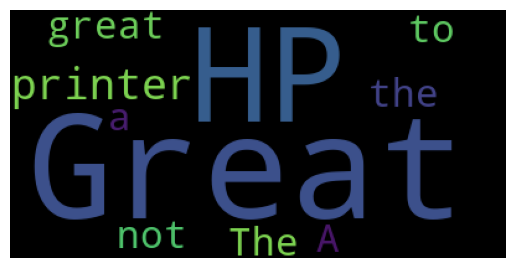

In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud().generate_from_frequencies(dic_top)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Exercícios

**Exercício 2**:

Descompacte o arquivo **amazon_sentiment_json_large.zip**. Garanta que existe uma pasta **amazon_sentiment_json_large** com arquivos **JSON**.

Abra como um Dask Bag.

In [47]:
jd = db.read_text('amazon_sentiment_json_small/amazon_sentiment_json_small/*.json').map(json.loads)
jd

dask.bag<loads, npartitions=2>

**Exercício 3**:

Conte quantos elementos (reviews) temos em nossa base.

In [48]:
jd.count().compute()

40

**Exercício 4**:

Crie uma nova coluna no json chamada **"text_complete"**.

Ela deve conter a concatenação do texto do título com o texto do review (campos `title` e `text`).

In [49]:
jd['text_complete'] = jd['title'] + ' ' + jd['text']

# Compute and display the updated DataFrame
result = jd.compute()
print(result.head())

**Exercício 5**:

Vamos trabalhar com o **"text_complete"**.

Filtre apenas este campo em uma nova Bag!

Converta tudo para minúsculo e faça a limpeza de toda pontuação.

**Dica**:
```python
import string
string.punctuation
```

In [50]:
# Seu código AQUI

**Exercício 6**:

Gere uma lista única (`flatten`) de palavras.

Além disso, sabemos que algumas palavras não são significativas (`the`, `a`, `an`, etc.). Chamamos ela de **stop-words**. Crie uma lista de stop-words (você pode inventar algumas), que representará palavras a serem ignoradas na análise. Filtre-as, removendo da lista.

**Dica**:
```python
import string
string.punctuation
```

In [51]:
# Seu código AQUI

Depois que fizer uma primeira versão do exercício, tente utilizar uma lista de stop-words pré-definida:


**Dica**:
```python
import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
print(stopwords.words('english'))
```

**Exercício 7**:

Gere a tabela de frequência das palavras e extraia as top 50 palavras mais frequentes.

In [52]:
# Seu código AQUI

**Exercício 8**:

Gere uma nuvem de palavras das 50 palavras mais frequentes

In [53]:
# Seu código AQUI

### Comparando Parquet e CSV

Para relembrar Data Frames, vamos comparar a velocidade de leitura do Dask com Parque e CSV.

**Exercício 9**:

Considerando os **JSON** originais, leia como Bag e faça a conversão para DataFrame.

Exporte o Data Frame para CSV e para Parquet (pesquise como fazer).

In [54]:
# Seu código AQUI

**Exercício 10**:

Leia o CSV exportado na linha anterior e conte a quantidade de linhas, monitorando o tempo necessário para execução.

In [55]:
%% time

# Seu código AQUI

UsageError: Cell magic `%%` not found.


**Exercício 11**:

Leia o Parquet exportado e conte a quantidade de linhas, monitorando o tempo necessário para execução.

Compare com a versão CSV.

In [ ]:
%% time

# Seu código AQUI